# Churn-Prediction

The goal is to assist a fictitious business in retaining its customers by predicting the tendency to churn even before they actually do it.

In [0]:
# Import Libraries

from pyspark.sql import SparkSession, Window
from pyspark import SparkFiles
from pyspark.sql.functions import avg, col, concat, count, desc, \
asc, explode, lit, min, max, split, stddev, udf, isnan, when, rank, \
log, sqrt, cbrt, exp
from pyspark.sql.functions import sum as Fsum
from pyspark.sql.types import IntegerType

from pyspark.ml import Pipeline
from pyspark.ml.classification import LogisticRegression, \
LogisticRegressionModel, RandomForestClassifier, \
RandomForestClassificationModel, GBTClassifier, \
GBTClassificationModel
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.mllib.evaluation import MulticlassMetrics

from pyspark.ml.feature import CountVectorizer, IDF, Normalizer, \
PCA, RegexTokenizer, Tokenizer, StandardScaler, StopWordsRemover, \
StringIndexer, VectorAssembler, MaxAbsScaler
from pyspark.ml.regression import LinearRegression
from pyspark.ml.clustering import KMeans
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

from time import time

import re
import numpy as np
import scipy
import pandas as pd
import datetime
import matplotlib.pyplot as plt
import pyspark
from pandas.plotting import scatter_matrix

import seaborn as sns
import random

%matplotlib inline

random.seed(42)

In [0]:
# Create a Spark session
spark = SparkSession.builder.getOrCreate()

# Load and Clean Dataset

The mini dataset file is music_log_small.json. We load and clean the dataset, checking for invalid or missing data.

### 1.1 Load the Dataset

In [0]:
# Load the dataset
path = '/FileStore/tables/music_log_small.json'
df = spark.read.json(path)
df.head()

Out[7]: Row(artist='Showaddywaddy', auth='Logged In', firstName='Kenneth', gender='M', itemInSession=112, lastName='Matthews', length=232.93342, level='paid', location='Charlotte-Concord-Gastonia, NC-SC', method='PUT', page='NextSong', registration=1509380319284, sessionId=5132, song='Christmas Tears Will Fall', status=200, ts=1513720872284, userAgent='"Mozilla/5.0 (Windows NT 6.1) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/36.0.1985.125 Safari/537.36"', userId='1046')

In [0]:
df.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)



### 1.2 Check for Missing Values

In [0]:
# Examine the number of missing values in each column
print(f"Total number of rows in the dataset: {df.count()}.\n")
missing_count_total = 0

for coln in df.columns:
    missing_count = df.filter((isnan(df[coln])) | (df[coln].isNull()) | (df[coln] == "")).count()
    
    if missing_count > 0:
        nan_count = df.filter(isnan(df[coln])).count()
        null_count = df.filter(df[coln].isNull()).count()
        empty_str = df.filter(df[coln] == "").count()
        print(f"{coln}: {missing_count} missing values. \
        {nan_count} NaN's; {null_count} Null's; {empty_str} empty strings.")
        missing_count_total += missing_count
        
if missing_count_total == 0:
    print("No missing values.")

Total number of rows in the dataset: 10000.

artist: 1653 missing values.         0 NaN's; 1653 Null's; 0 empty strings.
firstName: 336 missing values.         0 NaN's; 336 Null's; 0 empty strings.
gender: 336 missing values.         0 NaN's; 336 Null's; 0 empty strings.
lastName: 336 missing values.         0 NaN's; 336 Null's; 0 empty strings.
length: 1653 missing values.         0 NaN's; 1653 Null's; 0 empty strings.
location: 336 missing values.         0 NaN's; 336 Null's; 0 empty strings.
registration: 336 missing values.         0 NaN's; 336 Null's; 0 empty strings.
song: 1653 missing values.         0 NaN's; 1653 Null's; 0 empty strings.
userAgent: 336 missing values.         0 NaN's; 336 Null's; 0 empty strings.
userId: 336 missing values.         0 NaN's; 0 Null's; 336 empty strings.


### Missing Values in `userId ` and `sessionId`

In [0]:
# Remove rows that have NaN in either userId or sessionId
num_rows = df.count()
print(f"There are {df.count()} rows in the dataset.")

df = df.dropna(how='any', subset=['userId', 'sessionId'])
print(f"There are {num_rows - df.count()} NaN's in either userId or sessionId. These rows are dropped.")

There are 10000 rows in the dataset.
There are 0 NaN's in either userId or sessionId. These rows are dropped.


In [0]:
# Preview the values of userId
df.select(['userId']).dropDuplicates().orderBy(df['userId']).show(10)

+------+
|userId|
+------+
|      |
|    10|
|   100|
|  1000|
|  1003|
|  1005|
|  1006|
|  1017|
|  1019|
|  1020|
+------+
only showing top 10 rows



In [0]:
# Create a view to run SQL queries
df.createOrReplaceTempView("df_table")

In [0]:
# page events of users whose userId IS an empty string
spark.sql(
    '''
    SELECT DISTINCT page
    FROM df_table
    WHERE userId == ""
    '''
).show()

+-----+
| page|
+-----+
| Home|
|About|
|Login|
| Help|
+-----+



In [0]:
# page events of users whose userId is NOT an empty string
spark.sql(
    '''
    SELECT DISTINCT page
    FROM df_table
    EXCEPT
    SELECT DISTINCT page
    FROM df_table
    WHERE userId == ""
    '''
).show()

+----------------+
|            page|
+----------------+
|Submit Downgrade|
|       Downgrade|
|          Logout|
|   Save Settings|
|        Settings|
|        NextSong|
|         Upgrade|
|           Error|
|  Submit Upgrade|
+----------------+



An `userId` of empty string likely represents user(s) who are in the middle of or prior to sign-in or registration. Therefore, the rows corresponding to empty `userId` are dropped.

In [0]:
# Drop rows that have empty userId
df = df.filter(df['userId'] != "")

In [0]:
# Check the number of missing values in userId and sessionId
print("Number of missing values:")
for coln in ['userId', 'sessionId', 'firstName', 'gender', 'lastName', 'location', 'registration', 'userAgent']:
    missing_count = df.filter((isnan(df[coln])) | (df[coln].isNull()) | (df[coln] == "")).count()
    print(f"    {coln}: {missing_count} missing values.")

Number of missing values:
    userId: 0 missing values.
    sessionId: 0 missing values.
    firstName: 0 missing values.
    gender: 0 missing values.
    lastName: 0 missing values.
    location: 0 missing values.
    registration: 0 missing values.
    userAgent: 0 missing values.


### Missing values in `artist`, `length` and  `song`

In [0]:
# page events of null artist values
df.filter(df['artist'].isNull()).select(df['page']).dropDuplicates().show()

+----------------+
|            page|
+----------------+
|Submit Downgrade|
|            Home|
|       Downgrade|
|          Logout|
|   Save Settings|
|           About|
|        Settings|
|            Help|
|         Upgrade|
|           Error|
|  Submit Upgrade|
+----------------+



In [0]:
# page events of NOT null artist values
df.filter(df['artist'].isNotNull()).select(df['page']).dropDuplicates().show()

+--------+
|    page|
+--------+
|NextSong|
+--------+



Only page event "NextSong", i.e. playing a song, has corresponding artist information. This should apply for each of the `artist`, `length`, and `song` columns

In [0]:
# Check the number of missing values of artist, length, song columns when page event is "NextSong"
df_song = df.filter(df['page'] == "NextSong")
print("When page event is 'NextSong':")
for coln in ['artist', 'length', 'song']:
    missing_count = df_song.filter((isnan(df[coln])) | (df[coln].isNull()) | (df[coln] == "")).count()
    print(f"    {coln}: {missing_count} missing values.")

When page event is 'NextSong':
    artist: 0 missing values.
    length: 0 missing values.
    song: 0 missing values.


# Exploratory Data Analysis

In [0]:
# Number of unique userId's to be sampled for exploratory data analysis
user_sample_size = 250

# Unique userId's from the full dataset
users = [row.userId for row in df.select('userId').dropDuplicates().collect()]

# Sample userId's
if len(users) > user_sample_size:
    user_sample = list(np.random.choice(users, size=user_sample_size, replace=False))
else:
    user_sample = list(np.copy(users))

# Create subset of the full dataset
df_sub = df.filter(df['userId'].isin(user_sample))

### 2.1 Overview of numerical columns

A quick look at descriptive statistics.

In [0]:
# Numerical columns (except for sessionId)
num_cols = ['itemInSession', 'registration', 'status', 'ts', 'length']

In [0]:
# Describe numerical columns (except for sessionId)
df_sub.select(num_cols).describe().show()

+-------+-----------------+--------------------+------------------+--------------------+------------------+
|summary|    itemInSession|        registration|            status|                  ts|            length|
+-------+-----------------+--------------------+------------------+--------------------+------------------+
|  count|             2274|                2274|              2274|                2274|              1959|
|   mean|17.28364116094987|1.504122617364474...| 201.2145998240985|1.513782551727271...|252.54690288922936|
| stddev|22.68912354145204|  8.51928172571949E9|12.081175710541734| 3.320398449297472E7|106.95198836292624|
|    min|                0|       1467993386284|               200|       1513720872284|           1.12281|
|    max|              118|       1513672672284|               404|       1513848193284|         1806.8371|
+-------+-----------------+--------------------+------------------+--------------------+------------------+



In [0]:
# Possible values of status
coln = 'status'
print(f"Possible values of '{coln}':")
print([x[coln] for x in df_sub.select(coln).dropDuplicates().collect()])

Possible values of 'status':
[307, 404, 200]


`status` values do not have continuous meaning, so we can consider it as a categorical variable.

### 2.2 Overview of non-numerical columns

A quick look at the possible categories.

In [0]:
# Non-numerical columns (except for userId)
cat_cols = ['artist', 'auth', 'firstName', 'lastName', 'gender', 'level', 'location',
            'method', 'page', 'song', 'userAgent']

In [0]:
# Possible values of auth
coln = 'auth'
print(f"Possible values of '{coln}':")
print([x[coln] for x in df_sub.select(coln).dropDuplicates().collect()])

Possible values of 'auth':
['Logged In']


In [0]:
# Possible values of gender
coln = 'gender'
print(f"Possible values of '{coln}':")
print([x[coln] for x in df_sub.select(coln).dropDuplicates().collect()])

Possible values of 'gender':
['F', 'M']


In [0]:
# Possible values of level
coln = 'level'
print(f"Possible values of '{coln}':")
print([x[coln] for x in df_sub.select(coln).dropDuplicates().collect()])

Possible values of 'level':
['free', 'paid']


In [0]:
# Possible values of method
coln = 'method'
print(f"Possible values of '{coln}':")
print([x[coln] for x in df_sub.select(coln).dropDuplicates().collect()])

Possible values of 'method':
['PUT', 'GET']


In [0]:
# Possible values of page
coln = 'page'
print(f"Possible values of '{coln}':")
print([x[coln] for x in df_sub.select(coln).dropDuplicates().collect()])

Possible values of 'page':
['Home', 'Downgrade', 'Logout', 'Save Settings', 'About', 'Settings', 'NextSong', 'Help', 'Upgrade', 'Error', 'Submit Upgrade']


In [0]:
# Possible values of userAgent
coln = 'userAgent'
print(f"Possible values of '{coln}':")
print([x[coln] for x in df_sub.select(coln).dropDuplicates().collect()[:10]])

Possible values of 'userAgent':
['"Mozilla/5.0 (Macintosh; Intel Mac OS X 10_8_5) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/36.0.1985.143 Safari/537.36"', '"Mozilla/5.0 (Windows NT 5.1) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/36.0.1985.143 Safari/537.36"', '"Mozilla/5.0 (iPhone; CPU iPhone OS 7_1_2 like Mac OS X) AppleWebKit/537.51.1 (KHTML, like Gecko) GSA/4.1.0.31802 Mobile/11D257 Safari/9537.53"', '"Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_3) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/37.0.2062.94 Safari/537.36"', '"Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/36.0.1985.125 Safari/537.36"', 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10.7; rv:31.0) Gecko/20100101 Firefox/31.0', 'Mozilla/5.0 (Windows NT 6.1; WOW64; rv:30.0) Gecko/20100101 Firefox/30.0', '"Mozilla/5.0 (Macintosh; Intel Mac OS X 10_8_5) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/36.0.1985.125 Safari/537.36"', 'Mozilla/5.0 (Windows NT 6.3; WOW64; rv:31.0) Ge

In [0]:
# A status of 404 corresponds to a page event "Error"
df_sub.select(['status', 'page']).where(df_sub['status']==404).dropDuplicates().show()

+------+-----+
|status| page|
+------+-----+
|   404|Error|
+------+-----+



### Define Churn

Once we've done the preliminary analysis, we create a column `Churn` to use as the label for our model. We use `Cancellation Confirmation` events to define churn for both paid and free users.

In [0]:
flag_churn_event = udf(lambda x: 1 if x == "Cancellation Confirmation" else 0, IntegerType())
df_sub = df_sub.withColumn("churned", flag_churn_event("page"))

In [0]:
# Calculate percentage of users who churned
pctg = df_sub.groupBy('userId').agg({'churned': 'sum'})\
    .select(avg('sum(churned)')).collect()[0]['avg(sum(churned))']
print(f"{round(pctg*100, 1)}% users have churned.")

0.0% users have churned.


In [0]:
# Calculate flags of churn
windowval = Window.partitionBy("userId").orderBy(asc("ts")).rangeBetween(Window.unboundedPreceding, 0)

# 1 means the user has already churned at this timestamp
df_sub = df_sub.withColumn("churnPhase", Fsum('churned').over(windowval))

# 1 means the user is a churn user
df_sub = df_sub.withColumn("churnUser", max('churned').over(Window.partitionBy("userId")))

### Explore Data

Once we've defined churn, we perform some exploratory data analysis to observe the behavior for users who stayed vs those who churned.

In [0]:
# Calculate the hour, day, weekday of the timestamp ts
get_hour = udf(lambda x: datetime.datetime.fromtimestamp(x / 1000.0).hour, IntegerType())
df_sub = df_sub.withColumn("hour", get_hour(df_sub.ts))

get_day = udf(lambda x: datetime.datetime.fromtimestamp(x / 1000.0).day, IntegerType())
df_sub = df_sub.withColumn("day", get_day(df_sub.ts))

get_weekday = udf(lambda x: datetime.datetime.fromtimestamp(x / 1000.0).weekday(), IntegerType())
df_sub = df_sub.withColumn("weekday", get_weekday(df_sub.ts))

# Calculate occurance of pageDowngrade
flag_downgrade_event = udf(lambda x: 1 if x == "Submit Downgrade" else 0, IntegerType())
df_sub = df_sub.withColumn("pageDowngrade", flag_downgrade_event("page"))

# Calculate flags of downgrade; 1 means has downgraded from paid to free
df_sub = df_sub.withColumn("pageDowngradePhase", Fsum('pageDowngrade').over(windowval))

In [0]:
# Create a view to run SQL queries
df_sub.createOrReplaceTempView("df_sub_table")

**Churn Vs Hour**

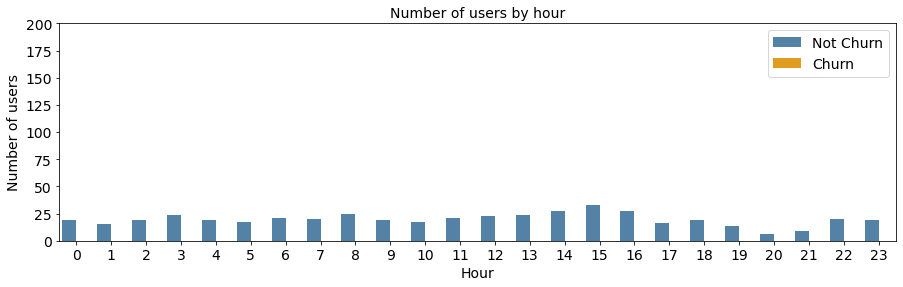

In [0]:
# Visualize the number of users by hour
func_churn_label = udf(lambda x: 'Churn' if x == 1 else 'Not Churn')
hour_users_pd = df_sub.select(['userId', 'hour', 'churnUser']).dropDuplicates()\
    .withColumn('churnUser', func_churn_label('churnUser'))\
    .toPandas()

fig = plt.figure(figsize=(15, 4))
sns.countplot(x="hour", hue="churnUser", data=hour_users_pd,
              hue_order=['Not Churn', 'Churn'],palette=['steelblue', 'orange']);
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.ylim(0, 200)
plt.xlabel("Hour", fontsize=14)
plt.ylabel("Number of users", fontsize=14)
plt.title("Number of users by hour", fontsize=14)
plt.legend(loc='best', fontsize=14);

/databricks/python/lib/python3.9/site-packages/seaborn/categorical.py:3717: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
<Figure size 1080x288 with 0 Axes>

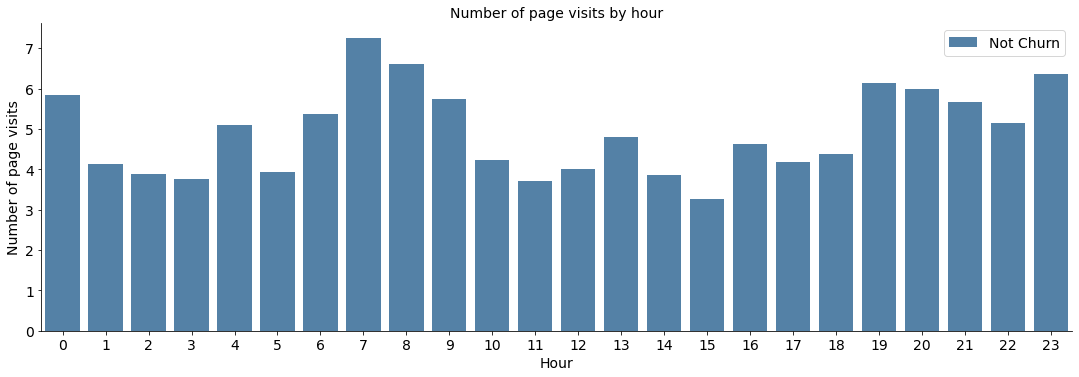

In [0]:
# Visualize the usage (i.e. the number of page events) by hour
hour_usage_pd = df_sub.groupBy(['userId', 'hour']).agg(count('page'), max('churnUser'))\
    .withColumn('max(churnUser)', func_churn_label('max(churnUser)'))\
    .toPandas()

fig = plt.figure(figsize=(15, 4))
sns.factorplot(x="hour", y="count(page)", hue="max(churnUser)", data=hour_usage_pd,
               palette=['steelblue', 'orange'], ci=None, kind="bar", aspect=3, legend=False);
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel("Hour", fontsize=14)
plt.ylabel("Number of page visits", fontsize=14)
plt.title("Number of page visits by hour", fontsize=14)
plt.legend(loc='best', fontsize=14);

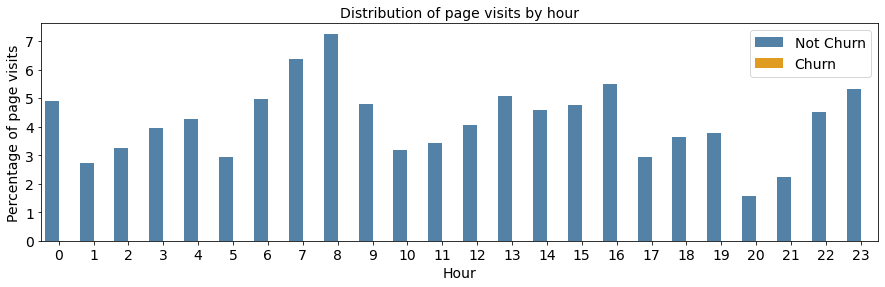

In [0]:
# Visualize the percentage of page events by hour
func_churn_label = udf(lambda x: 'Churn' if x == 1 else 'Not Churn')

hour_usage_pd = df_sub.withColumn('churnUser', func_churn_label('churnUser'))\
    .toPandas()
hour_usage_pd = hour_usage_pd.groupby(['churnUser'])['hour']\
    .value_counts(normalize=True).rename('percentage').mul(100).reset_index()

fig = plt.figure(figsize=(15, 4))
sns.barplot(x="hour", y="percentage", hue="churnUser", data=hour_usage_pd,
              hue_order=['Not Churn', 'Churn'],palette=['steelblue', 'orange']);
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel("Hour", fontsize=14)
plt.ylabel("Percentage of page visits", fontsize=14)
plt.title("Distribution of page visits by hour", fontsize=14)
plt.legend(loc='best', fontsize=14);

**Churn Vs Weekday**

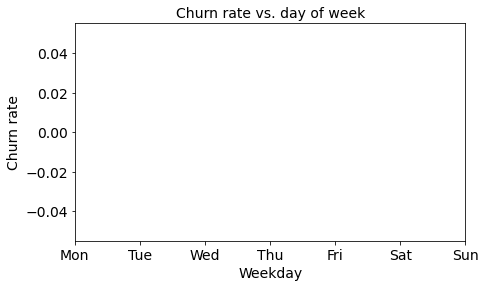

In [0]:
# Calculate day counts
daily = df_sub.select(['userId', 'weekday', 'churnUser'])\
    .dropDuplicates()\
    .groupBy('weekday')\
    .agg(count('userId').alias('num_users'), Fsum('churnUser').alias('num_churns'))
daily_df = daily.toPandas()

# Visualize weekday patterns
plt.figure(figsize=(7,4))
plt.bar(daily_df['weekday'], daily_df['num_churns'] / daily_df['num_users'],color=['orange'])
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel("Weekday", fontsize=14)
plt.ylabel("Churn rate", fontsize=14)
plt.xticks(range(7), ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'])
plt.title("Churn rate vs. day of week", fontsize=14);

Saturday has highest churn rate. This seems to suggest that the Friday users cohort are more likely to churn.

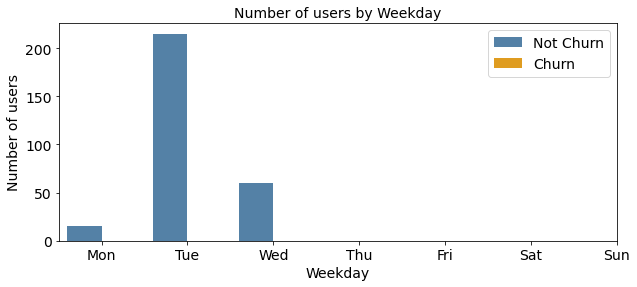

In [0]:
# Visualize the number of users by weekday
func_churn_label = udf(lambda x: 'Churn' if x == 1 else 'Not Churn')
weekday_users_pd = df_sub.select(['userId', 'weekday', 'churnUser']).dropDuplicates()\
    .withColumn('churnUser', func_churn_label('churnUser'))\
    .toPandas()

fig = plt.figure(figsize=(10, 4))
sns.countplot(x="weekday", hue="churnUser", data=weekday_users_pd,
              hue_order=['Not Churn', 'Churn'],palette=['steelblue', 'orange']);
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel("Weekday", fontsize=14)
plt.ylabel("Number of users", fontsize=14)
plt.title("Number of users by Weekday", fontsize=14)
plt.xticks(range(7), ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'])
plt.legend(loc='best', fontsize=14);

/databricks/python/lib/python3.9/site-packages/seaborn/categorical.py:3717: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
<Figure size 720x288 with 0 Axes>

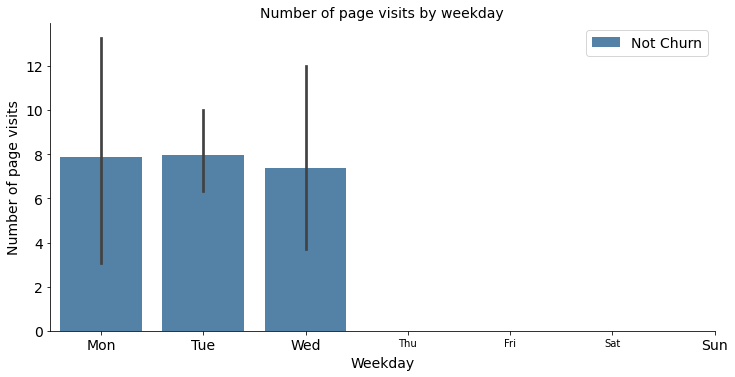

In [0]:
# Visualize the usage (i.e. the number of page events) by weekday
func_churn_label = udf(lambda x: 'Churn' if x == 1 else 'Not Churn')
weekday_usage_pd = df_sub.groupBy(['userId', 'weekday']).agg(count('page'), max('churnUser'))\
    .withColumn('max(churnUser)', func_churn_label('max(churnUser)'))\
    .toPandas()

fig = plt.figure(figsize=(10, 4))
sns.factorplot(x="weekday", y="count(page)", hue="max(churnUser)", data=weekday_usage_pd,
#                palette=['steelblue', 'orange'], ci=None,
               kind="bar", aspect=2, legend=False,palette=['steelblue', 'orange']);
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel("Weekday", fontsize=14)
plt.ylabel("Number of page visits", fontsize=14)
plt.title("Number of page visits by weekday", fontsize=14)
plt.xticks(range(7), ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'])
plt.legend(loc='best', fontsize=14);

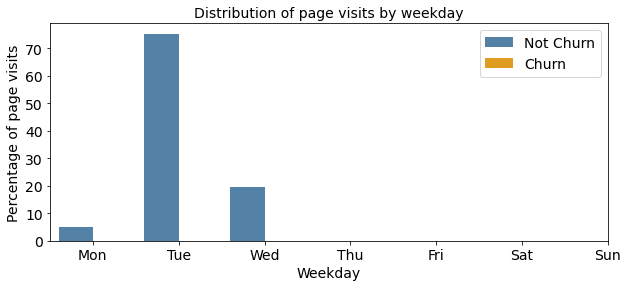

In [0]:
# Visualize the percentage of page events by weekday
func_churn_label = udf(lambda x: 'Churn' if x == 1 else 'Not Churn')

weekday_usage_pd = df_sub.withColumn('churnUser', func_churn_label('churnUser'))\
    .toPandas()
weekday_usage_pd = weekday_usage_pd.groupby(['churnUser'])['weekday']\
    .value_counts(normalize=True).rename('percentage').mul(100).reset_index()

fig = plt.figure(figsize=(10, 4))
sns.barplot(x="weekday", y="percentage", hue="churnUser", data=weekday_usage_pd,
              hue_order=['Not Churn', 'Churn'],palette=['steelblue', 'orange']);
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel("Weekday", fontsize=14)
plt.ylabel("Percentage of page visits", fontsize=14)
plt.xticks(range(7), ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'])
plt.title("Distribution of page visits by weekday", fontsize=14)
plt.legend(loc='best', fontsize=14);

**Churn Vs Level**

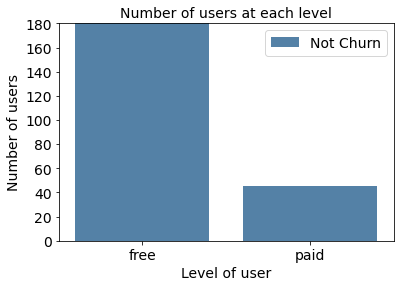

In [0]:
# Visualize the number of users by level
func_churn_label = udf(lambda x: 'Churn' if x == 1 else 'Not Churn')
level_users_pd = df_sub.select(['userId', 'level', 'churnUser']).dropDuplicates()\
    .withColumn('churnUser', func_churn_label('churnUser'))\
    .toPandas()

fig = plt.figure(figsize=(6, 4))
sns.countplot(x="level", hue="churnUser", data=level_users_pd,palette=['steelblue', 'orange'])
plt.ylim(0, 180)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel("Level of user", fontsize=14)
plt.ylabel("Number of users", fontsize=14)
plt.title("Number of users at each level", fontsize=14)
plt.legend(loc='best', fontsize=14);

/databricks/python/lib/python3.9/site-packages/seaborn/categorical.py:3717: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
<Figure size 432x288 with 0 Axes>

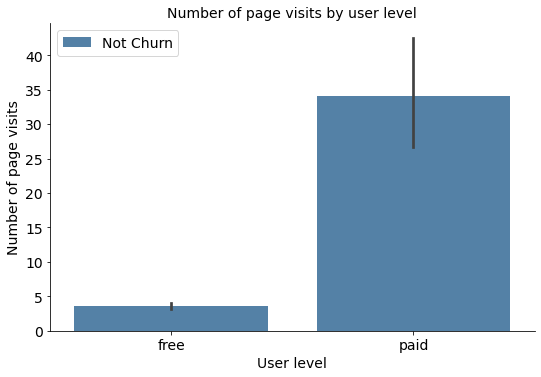

In [0]:
# Visualize the usage (i.e. the number of page events) by level
func_churn_label = udf(lambda x: 'Churn' if x == 1 else 'Not Churn')
level_usage_pd = df_sub.groupBy(['userId', 'level']).agg(count('page'), max('churnUser'))\
    .withColumn('max(churnUser)', func_churn_label('max(churnUser)'))\
    .toPandas()

fig = plt.figure(figsize=(6, 4))
sns.factorplot(x="level", y="count(page)", hue="max(churnUser)", data=level_usage_pd,palette=['steelblue', 'orange'],kind="bar", aspect=1.5, legend=False);
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel("User level", fontsize=14)
plt.ylabel("Number of page visits", fontsize=14)
plt.title("Number of page visits by user level", fontsize=14)
plt.legend(loc='best', fontsize=14);

There are more free users than paid users, and the free users are slightly more likely to churn.

**Churn Vs Page Events**

In [0]:
# Create pivot table of page events
pages = df_sub.groupBy(['userId']).pivot('page').count().fillna(0)
pages_df = pages.toPandas()

pages_df = pages_df.rename(columns={"Cancellation Confirmation": "Churn"})
pages_df.head()

,userId,About,Downgrade,Error,Help,Home,Logout,NextSong,Save Settings,Settings,Submit Upgrade,Upgrade
0,2162,0,1,0,2,2,0,34,0,0,0,0
1,2904,0,0,0,0,0,0,1,0,0,0,0
2,2088,0,0,0,0,1,0,13,0,0,0,0
3,800,0,0,0,0,1,0,2,0,0,0,0
4,2696,0,0,0,0,1,0,1,0,0,0,0


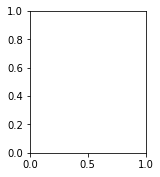

---------------------------------------------------------------------------
KeyError                                  Traceback (most recent call last)
<command-2967774331460216> in <cell line: 7>()
      7 for i, coln in enumerate(cols_interest):
      8     ax = fig.add_subplot(4,5,i+1)
----> 9     pages_df.boxplot(coln,ax=ax,grid=False,by='Churn', showfliers=False)
     10 
     11 fig.suptitle('')

/databricks/python/lib/python3.9/site-packages/pandas/plotting/_core.py in boxplot_frame(self, column, by, ax, fontsize, rot, grid, figsize, layout, return_type, backend, **kwargs)
    509 ):
    510     plot_backend = _get_plot_backend(backend)
--> 511     return plot_backend.boxplot_frame(
    512         self,
    513         column=column,

/databricks/python/lib/python3.9/site-packages/pandas/plotting/_matplotlib/boxplot.py in boxplot_frame(self, column, by, ax, fontsize, rot, grid, figsize, layout, return_type, **kwds)
    392     import matplotlib.pyplot as plt
    393 
--> 394   

In [0]:
# Visualize churn patterns by page event
fig = plt.figure(figsize=(12, 12))
cols_interest = ['About', 'Add Friend', 'Add to Playlist', 'Downgrade', 'Error', 'Help', 'Home', 
                 'Logout', 'NextSong', 'Roll Advert', 'Save Settings', 'Settings', 'Thumbs Down', 
                 'Thumbs Up', 'Upgrade']

for i, coln in enumerate(cols_interest):
    ax = fig.add_subplot(4,5,i+1)
    pages_df.boxplot(coln,ax=ax,grid=False,by='Churn', showfliers=False)

fig.suptitle('')
plt.tight_layout()

In general, churn users have less engagement (number of page events) than no-churn users. Churn users have generally added less friends, added less playlist, requested less help, listened less songs, and given less thumbs ups than thumbs downs. Interestingly, churn users have also encountered less errors, which on a second thought makes sense because churn users genrally engage less with Spotify and have less chances to encounter errors.

In [0]:
# Visualize the distribution of page events
pages_df['Churn'] = pages_df['Churn'].replace({1: "Churn", 0: "Not Churn"})
pages_df = pages_df.drop('Cancel', axis=1)

page_events_pd = pd.melt(
    pages_df, id_vars=['userId', 'Churn'], 
    value_vars=list(pages_df.columns[1:].drop('Churn')),
    var_name='page', 
    value_name='number_visits'
).reset_index()

fig = plt.figure(figsize=(10, 6))
sns.factorplot(x="page", y="number_visits", hue="Churn", data=page_events_pd,
               kind="bar", aspect=3, legend=False, log=True,palette=['steelblue','orange']);
plt.xticks(rotation=30, ha='right', fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel("Page event", fontsize=14)
plt.ylabel("Number of page visits", fontsize=14)
plt.title("Number of page visits", fontsize=14)
plt.legend(loc='best', fontsize=14);

In [0]:
# Visualize the distribution of page events fractions
pages_df['Churn'] = pages_df['Churn'].replace({1: "Churn", 0: "Not Churn"})
# pages_df = pages_df.drop('Cancel', axis=1)

pages_df_frac = pages_df.copy()
event_cols = [coln for coln in pages_df_frac.columns[1:] if coln != 'Churn']
pages_df_frac['total'] = pages_df_frac[event_cols].sum(axis=1)
for coln in event_cols:
    pages_df_frac[coln] = pages_df_frac[coln] / pages_df_frac['total']

page_events_frac_pd = pd.melt(
    pages_df_frac, id_vars=['userId', 'Churn'], 
    value_vars=event_cols,
    var_name='page', 
    value_name='frac_visits'
).reset_index()

fig = plt.figure(figsize=(10, 6))
sns.factorplot(x="page", y="frac_visits", hue="Churn", data=page_events_frac_pd,
               kind="bar", aspect=3, legend=False, log=True,palette=['steelblue','orange']);
plt.xticks(rotation=30, ha='right', fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel("Page event", fontsize=14)
plt.ylabel("Fraction of page visits", fontsize=14)
plt.title("Fraction of page visits", fontsize=14)
plt.legend(loc='best', fontsize=14);

In [0]:
# Visualize the frequency of thumbs up vs. thumbs down
pages_df['Thumbs Up Frequency'] = pages_df['Thumbs Up'] / pages_df['NextSong'] * 100
pages_df['Thumbs Down Frequency'] = pages_df['Thumbs Down'] / pages_df['NextSong'] * 100

page_events_pd2 = pd.melt(
    pages_df[['userId', 'Churn', 'Thumbs Up Frequency', 'Thumbs Down Frequency']], 
    id_vars=['userId', 'Churn'], 
    value_vars=['Thumbs Up Frequency', 'Thumbs Down Frequency'],
    var_name='page', 
    value_name='ratio'
).reset_index()
page_events_pd2['page'] = page_events_pd2['page']\
    .replace({"Thumbs Up Frequency": "Thumbs Up", 
              "Thumbs Down Frequency": "Thumbs Down"})

fig = plt.figure(figsize=(10, 6))
sns.factorplot(x="page", y="ratio", hue="Churn", data=page_events_pd2,
               kind="bar", aspect=1.5, legend=False,palette=['steelblue','orange']);
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel("Page event", fontsize=14)
plt.ylabel("Frequency", fontsize=14)
plt.title("Frequency of thumbs up and thumbs down", fontsize=14)
plt.legend(loc='best', fontsize=14);

**Churn Vs Device Used**

In [0]:
# Calculate churns by device
func_agent_device = udf(lambda x: x.split('(')[1].replace(";", " ").split(" ")[0])
df_sub_device = df_sub.withColumn("userAgent", func_agent_device(df_sub["userAgent"]))
df_sub_device.createOrReplaceTempView("df_sub_device_table")

device = df_sub_device.select(['userId', 'userAgent', 'churnUser'])\
    .dropDuplicates()\
    .groupBy('userAgent')\
    .agg(count('userId').alias('num_users'), Fsum('churnUser').alias('num_churns'))
device_df = device.toPandas()

# Visualize device patterns
plt.figure(figsize=(10,4))
plt.bar(device_df['userAgent'], device_df['num_churns'] / device_df['num_users'],color='orange')
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel("User device", fontsize=14)
plt.ylabel("Churn rate", fontsize=14)
plt.title("Churn rate vs. user device", fontsize=14);

In [0]:
# Calculate churns by device
func_churn_label = udf(lambda x: 'Churn' if x == 1 else 'Not Churn')
func_agent_device = udf(lambda x: x.split('(')[1].replace(";", " ").split(" ")[0])

df_sub_device = df_sub.withColumn("userAgent", func_agent_device(df_sub["userAgent"]))
device_pd = df_sub_device.select(["userId", 'userAgent', 'churnUser'])\
    .dropDuplicates()\
    .withColumn('churnUser', func_churn_label('churnUser'))\
    .toPandas()

fig = plt.figure(figsize=(10, 4))
sns.countplot(x="userAgent", hue="churnUser", data=device_pd,palette=['steelblue','orange']);
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel("Device used", fontsize=14)
plt.ylabel("Number of users", fontsize=14)
plt.title("Distribution of device usage", fontsize=14)
plt.legend(loc='best', fontsize=14);

**Time from downgrade to churn**

In [0]:
# For those who downgraded and churn, calculate time from downgrade to churn
downgrade_to_churn = df_sub.filter((df_sub['churnUser']==1) & (df_sub['pageDowngradePhase']==1))\
    .groupBy(['userId']).agg(max('ts')-min('ts'))\
    .withColumnRenamed('(max(ts) - min(ts))','timeDownToChurn')

# Report the time from downgrade to churn in hours
hours_to_churn = downgrade_to_churn.withColumn("hourDownToChurn", downgrade_to_churn["timeDownToChurn"]/1000/3600)\
    .select(['userId', 'hourDownToChurn'])
hours_to_churn_pd = hours_to_churn.toPandas()

# Visualize time from downgrade to churn
(hours_to_churn_pd['hourDownToChurn']/24).hist(color='orange')
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel("Number of days", fontsize=14)
plt.ylabel("Count", fontsize=14)
plt.title("Distribution of time from downgrade to churn", fontsize=14);

# Feature Engineering
In this section, we will build features useful to train the model on.

In [0]:
# Number of unique userId's to be sampled for exploratory data analysis
user_sample_size = 250

# Unique userId's from the full dataset
users = [row.userId for row in df.select('userId').dropDuplicates().collect()]

# Sample userId's
if len(users) > user_sample_size:
    user_sample = list(np.random.choice(users, size=user_sample_size, replace=False))
else:
    user_sample = list(np.copy(users))

# Create subset of the full dataset
df_sub2 = df.filter(df['userId'].isin(user_sample))
print(f"{df_sub2.select('userId').dropDuplicates().count()} unique userIds.")

### 3.1. Create features on per user basis

Features to create on per user basis:

> - `page-Cancellation Confirmation:` Churn (binary)
> - `registration and ts`: Time since registration in seconds
    gender: Gender, "M"->1, "F"->0 (binary)
> - `level`: Level of user most recently, "paid"->1, "free"->0 (binary)
> - `artist`: Total number of unique artists the user has listened to (int)
> - `length`: Total length of songs listened (float)
> - `sessionId`: Total number of sessions (int)
> - `song`: Total number of songs the user has listened to (int)
> - `artist and song`: Statistics of the number of songs per artist that the user has listened to (float)
> - `sessionId and ts`: Statistics of the time spent per session (float)
> - `sessionId and song`: Statistics of the number of songs per session (float)
> - `userAgent`: User agents (binary)
> - `page`: Number of page events (int)
> > - Thumbs Up, Thumbs Down, Home, Roll Advert, Logout, Save Settings, About, Settings, Add to Playlist, Add Friend, NextSong, Help, Error, Submit Upgrade, Submit Downgrade
> - `location`: First listed location state (binary)

In [0]:
df_sub2.createOrReplaceTempView("df_sub2_table")

**Define Churn**

In [0]:
# Define churn
flag_churn_event = udf(lambda x: 1 if x == "Cancellation Confirmation" else 0, IntegerType())
churn = df_sub2.withColumn("churned", flag_churn_event("page"))\
    .select(['userId', 'churned'])\
    .groupBy('userId').agg(max('churned').alias("churn"))

print(f"{churn.count()} rows.")
print(f"{round(churn.select(avg('churn')).collect()[0]['avg(churn)']*100, 1)}% users churned.")
churn.show(5)

**Level Of User**

In [0]:
# Latest level
func_levels = udf(lambda x: 1 if x=="paid" else 0, IntegerType())
levels = df_sub2.select(['userId', 'level', 'ts'])\
    .orderBy(desc('ts'))\
    .dropDuplicates(['userId'])\
    .select(['userId', 'level'])\
    .withColumn('level', func_levels('level').cast(IntegerType()))

print(f"{levels.count()} rows.")
levels.show(5)

**Time since registration, and gender of user**

In [0]:
# Time since registration in seconds, and gender as binary
time_gender = spark.sql(
    '''
    SELECT userId, (MAX(ts) - AVG(registration)) / 1000 time_since_regi,
    AVG(CASE WHEN gender = "M" THEN 1 ELSE 0 END) gender
    FROM df_sub2_table
    GROUP BY userId
    '''
)

print(f"{time_gender.count()} rows.")
time_gender.show(5)

**Number of artists, total length, number of sessions, and number of songs that the user has engaged**

In [0]:
# Number of artists, total length, number of sessions, number of songs, and number of page events
# that the user has engaged
engagement = spark.sql(
    '''
    SELECT userId, COUNT(DISTINCT artist) num_artists_dist, 
    SUM(length) tot_length, COUNT(DISTINCT sessionId) num_sessions, 
    COUNT(song) num_songs, COUNT(DISTINCT song) num_songs_dist,
    COUNT(page) num_events
    FROM df_sub2_table
    GROUP BY userId
    '''
)

print(f"{engagement.count()} rows.")
engagement.show(5)

**Statistics of the number of songs per artist that the user has listened to**

In [0]:
# Statistics of the number of songs per artist that the user has listened to
per_artist = spark.sql(
    '''
    SELECT userId, MAX(num_songs) max_songs_per_artist, 
    AVG(num_songs) avg_songs_per_artist, stddev_samp(num_songs) std_songs_per_artist
    FROM
        (SELECT userId, artist, COUNT(song) as num_songs
        FROM df_sub2_table
        WHERE (artist IS NOT NULL)
        GROUP BY userId, artist) songs_per_artist
    GROUP BY userId
    '''
).fillna(0)

print(f"{per_artist.count()} rows.")
per_artist.show(5)

**Statistics of the time spent and the number of songs per session**

In [0]:
# Statistics of the time spent and the number of songs per session (float)
per_session = spark.sql(
    '''
    SELECT userId, MAX(num_songs) max_songs_per_session, 
    AVG(num_songs) avg_songs_per_session, stddev_samp(num_songs) std_songs_per_session,
    MAX(time) max_time_per_session, AVG(time) avg_time_per_session, 
    stddev_samp(time) std_time_per_session
    FROM
        (SELECT userId, sessionId, (MAX(ts) - MIN(ts))/1000 AS time, COUNT(song) num_songs
        FROM df_sub2_table
        GROUP BY userId, sessionId) per_session
    GROUP BY userId
    '''
).fillna(0)

print(f"{per_session.count()} rows.")
per_session.show(5)

**Calculate usage of each userAgent**

In [0]:
# Calculate usage fraction of each userAgent
window = Window.partitionBy("userId").rowsBetween(Window.unboundedPreceding,Window.unboundedFollowing)
func_agent_device = udf(lambda x: "user_agent_"+x.split('(')[1].replace(";", " ").split(" ")[0])

agents = df_sub2.withColumn("userAgent", func_agent_device(df_sub2["userAgent"]))\
    .select(["userId", 'userAgent'])\
    .groupBy(["userId", 'userAgent'])\
    .agg(count("userAgent").alias("user_agent_usage"))\
    .withColumn('total', Fsum(col('user_agent_usage')).over(window))\
    .withColumn('user_agent_usage', col('user_agent_usage')/col('total'))\
    .groupBy("userId").pivot("userAgent").sum("user_agent_usage").fillna(0)

print(f"{agents.count()} rows.")
agents.show(5)

**Calculate the count and fraction of each page event by each user**

In [0]:
# Count usages of each page event by each user
pages_to_exclude = ['Cancel', 'Downgrade', 'Cancellation Confirmation', 'Upgrade']
func_pages = udf(lambda x: "page_"+x.replace(" ", "_").lower())

pages = df_sub2.filter(~df_sub2['page'].isin(pages_to_exclude))\
    .withColumn("page", func_pages(df_sub2["page"]))\
    .groupBy(['userId']).pivot("page").agg(count('page'))\
    .fillna(0)
pages = pages.withColumn("page_up_down_ratio", pages["page_thumbs_up"]/(pages['page_thumbs_down']+0.1))

print(f"{pages.count()} rows.")
pages.show(2)

In [0]:
# Calculate the fraction of each page event by each user
pages = pages.withColumn(
    'total', sum(pages[coln] for coln in pages.columns if coln not in ['userId', 'page_up_down_ratio'])
)

for coln in pages.columns:
    if coln not in ['userId', 'total', 'page_up_down_ratio']:
        new_col_name = coln[0:5]+'frac_'+coln[5:]
        pages = pages.withColumn(new_col_name, pages[coln] / pages['total'])

pages = pages.drop('total')
print(f"{pages.count()} rows.")
pages.select([coln for coln in pages.columns if '_frac' in coln]).show(2)

**Find the first listed location region of each user**

In [0]:
# Load open source table that links state names to geographical divisions
# Load open source table that links state names to geographical divisions
region = pd.read_csv('https://raw.githubusercontent.com/cphalpert/census-regions/master/us%20census%20bureau%20regions%20and%20divisions.csv')
region.to_csv("region.csv", index=False)
path = "region.csv"
region = spark.read.csv(path, header=True)
region.show(5)

In [0]:
# Find the user's geographical division based on the first listed location state
func_locations = udf(lambda x: x.split(', ')[1].split('-')[0])
func_location_names = udf(lambda x: "location_"+x.replace(" ", "_").lower())

locations = df_sub2.withColumn('location', func_locations(df_sub2['location']))\
    .select(['userId', 'location']).dropDuplicates(subset=['userId'])

locations = locations.join(region, locations['location']==region['State Code'], how='left')\
    .select(['userId', col("Division").alias("location")])\
    .withColumn('location', func_location_names('location'))

locations = locations.groupBy('userId').pivot('location').agg(count('location')).fillna(0)

print(f"{locations.count()} rows.")
locations.show(2)

**Join engineered features together**

In [0]:
dataset = churn.join(levels, ['userId'])\
    .join(time_gender, ['userId'])\
    .join(engagement, ['userId'])\
    .join(per_artist, ['userId'])\
    .join(per_session, ['userId'])\
    .join(agents, ['userId'])\
    .join(pages, ['userId'])\
    .join(locations, ['userId'])

dataset.head()

### 3.2 Check multicollinearity

Remove features that are strongly correlated to others.

In [0]:
# Convert to pandas
dataset_pd = dataset.toPandas()

# Find correlated features that have absolute correlation >= 0.5
corr_matrix = dataset_pd.corr()
correlated_cols = []
for coln in corr_matrix.columns:
    correlated = corr_matrix.drop(coln, axis=0).loc[corr_matrix[coln].abs()>=0.5].index.tolist()
    if len(correlated) > 0:
        correlated_cols.append(coln)

In [0]:
# Find features to be removed, i.e. feature that has >0.8 correlation with any remaining feature
corr = dataset_pd[correlated_cols].corr()
cols_to_remove = []
counter = 0
for coln in corr.columns:
    counter += 1
    if corr[coln].iloc[counter:].max() >= 0.8:
        cols_to_remove.append(coln)
print(f"Highly correlated features that should be removed:\n\n{cols_to_remove}\n\n")
cols_to_keep = dataset_pd.columns.drop(cols_to_remove).tolist()
print(f"Features to keep:\n\n{cols_to_keep}")

For example, `page_nextsong`, i.e. the number of songs listened by each user, will be dropped because it correlates strongly (correlation coefficient = 0.97) with `page_thumbs_up`

In [0]:
# Visualize correlations of the remaining features
print("Correlations among the remaining features:")
cols_to_keep_corr = [coln for coln in cols_to_keep if ('user_agent' not in coln) & ('userId' not in coln)]
corr_remaining = dataset_pd[cols_to_keep_corr].corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr_remaining, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(20, 20))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
ax = sns.heatmap(
    corr_remaining, mask=mask, cmap=cmap, center=0,
    vmin=-1, vmax=1, 
    square=True, linewidths=.5, cbar_kws={"shrink": .5}, 
    xticklabels=cols_to_keep_corr,
    yticklabels=cols_to_keep_corr)
plt.xticks(rotation=45, ha='right', fontsize=14) 
plt.yticks(fontsize=14);
# ax.figure.axes[-1].yaxis.label.set_size(14)

There aren't extremely strong correlations (correlation coefficient >=0.8) left.

### 3.3 Feature transformation

Transform features so they are close to normal distributions.

**Examine feature distributions**

In [0]:
# Reset dataset
dataset = churn.join(levels, ['userId'])\
    .join(time_gender, ['userId'])\
    .join(engagement, ['userId'])\
    .join(per_artist, ['userId'])\
    .join(per_session, ['userId'])\
    .join(agents, ['userId'])\
    .join(pages, ['userId'])\
    .join(locations, ['userId'])

In [0]:
# Drop the highly correlated features
dataset = dataset.select(cols_to_keep)

In [0]:
# Convert to pandas
dataset_pd = dataset.toPandas()

In [0]:
# Confirm missing values
missing_value_count = dataset_pd.isnull().sum().sum()
print(f"{missing_value_count} missing values left.")

In [0]:
# Examine feature distributions (excluding binary features and submit page events)
print("Examine feature distributions:")
col_names = [coln for coln in dataset_pd.columns if 
             ('churn' not in coln) and 
             ('level' not in coln) and
             ('userId' not in coln) and
             ('gender' not in coln) and
             ('user_agent_' not in coln) and
             ('location_' not in coln) and
             ('_submit_' not in coln)
            ]
dataset_pd[col_names].hist(figsize=(15,15),color='orange');

Most of the features are skewed, so we will transform them to bring them closer to normal distributions

**Transform features so they are close to normal distributions**

In [0]:
to_sqrt = ['std_time_per_session']
to_log = [
    'page_about', 'page_error', 'page_roll_advert', 'page_save_settings', 
    'page_thumbs_down', 'page_frac_about', 'page_frac_add_friend', 
    'page_frac_add_to_playlist', 'page_frac_error', 'page_frac_help', 
    'page_frac_home', 'page_frac_logout', 'page_frac_roll_advert', 
    'page_frac_save_settings', 'page_frac_settings', 
    'page_frac_submit_downgrade', 'page_frac_submit_upgrade', 
    'page_frac_thumbs_down', 'page_settings', 'page_thumbs_up',
    'page_up_down_ratio'
]

for col_name in col_names:
    if col_name in to_sqrt:
        dataset = dataset.withColumn(col_name, sqrt(dataset[col_name]+1))
    elif col_name in to_log:
        dataset = dataset.withColumn(col_name, log(dataset[col_name]+1))

print("Examine feature distributions:")
dataset_pd = dataset.toPandas()
dataset_pd[col_names].hist(figsize=(15,15),color='orange');

The distributions are closer to normal now.

### 3.4 Compile feature engineering code to scale up later

**Load Data**

In [0]:
# Load data
path = 'music_log_small.json'
df = spark.read.json(path)

**Drop Missing Values**

In [0]:
df = df.dropna(how='any', subset=['userId', 'sessionId'])
df = df.filter(df['userId'] != "")

**Create Features**

In [0]:
df.createOrReplaceTempView("df_table")

# Define churn
flag_churn_event = udf(lambda x: 1 if x == "Cancellation Confirmation" else 0, IntegerType())
churn = df.withColumn("churned", flag_churn_event("page"))\
    .select(['userId', 'churned'])\
    .groupBy('userId').agg(max('churned').alias("churn"))

# Latest level
func_levels = udf(lambda x: 1 if x=="paid" else 0, IntegerType())
levels = df.select(['userId', 'level', 'ts'])\
    .orderBy(desc('ts'))\
    .dropDuplicates(['userId'])\
    .select(['userId', 'level'])\
    .withColumn('level', func_levels('level').cast(IntegerType()))

# Time since registration in seconds, and gender as binary
time_gender = spark.sql(
    '''
    SELECT userId, (MAX(ts) - AVG(registration)) / 1000 time_since_regi,
    AVG(CASE WHEN gender = "M" THEN 1 ELSE 0 END) gender
    FROM df_table
    GROUP BY userId
    '''
)

# Statistics of the time spent sper session (float)
per_session = spark.sql(
    '''
    SELECT userId, stddev_samp(time) std_time_per_session
    FROM
        (SELECT userId, sessionId, (MAX(ts) - MIN(ts))/1000 AS time, COUNT(song) num_songs
        FROM df_table
        GROUP BY userId, sessionId) per_session
    GROUP BY userId
    '''
).fillna(0)

In [0]:
# Calculate usage fraction of each userAgent
window = Window.partitionBy("userId").rowsBetween(Window.unboundedPreceding,Window.unboundedFollowing)
func_agent_device = udf(lambda x: "user_agent_"+x.split('(')[1].replace(";", " ").split(" ")[0])

agents = df.withColumn("userAgent", func_agent_device(df["userAgent"]))\
    .select(["userId", 'userAgent'])\
    .groupBy(["userId", 'userAgent'])\
    .agg(count("userAgent").alias("user_agent_usage"))\
    .withColumn('total', Fsum(col('user_agent_usage')).over(window))\
    .withColumn('user_agent_usage', col('user_agent_usage')/col('total'))\
    .groupBy("userId").pivot("userAgent").sum("user_agent_usage").fillna(0)

# Count usages of each page event by each user
pages_to_exclude = ['Cancel', 'Downgrade', 'Cancellation Confirmation', 'Upgrade']
func_pages = udf(lambda x: "page_"+x.replace(" ", "_").lower())
pages = df.filter(~df['page'].isin(pages_to_exclude))\
    .withColumn("page", func_pages(df["page"]))\
    .groupBy(['userId']).pivot("page").agg(count('page'))\
    .fillna(0)
pages = pages.withColumn("page_up_down_ratio", pages["page_thumbs_up"]/(pages['page_thumbs_down']+0.1))

# Calculate the fraction of each page event by each user
pages = pages.withColumn(
    'total', sum(pages[coln] for coln in pages.columns if coln not in ['userId', 'page_up_down_ratio'])
)
for coln in pages.columns:
    if coln not in ['userId', 'total', 'page_up_down_ratio']:
        new_col_name = coln[0:5]+'frac_'+coln[5:]
        pages = pages.withColumn(new_col_name, pages[coln] / pages['total'])
pages = pages.drop('total')

# Find the user's geographical division based on the first listed location state
path = "region.csv"
region = spark.read.csv(path, header=True)
func_locations = udf(lambda x: x.split(', ')[1].split('-')[0])
func_location_names = udf(lambda x: "location_"+x.replace(" ", "_").lower())
locations = df.withColumn('location', func_locations(df['location']))\
    .select(['userId', 'location']).dropDuplicates(subset=['userId'])
locations = locations.join(region, locations['location']==region['State Code'], how='left')\
    .select(['userId', col("Division").alias("location")])\
    .withColumn('location', func_location_names('location'))
locations = locations.groupBy('userId').pivot('location').agg(count('location')).fillna(0)

**Compile and transform features**

In [0]:
# Join features together
dataset = churn.join(levels, ['userId'])\
    .join(time_gender, ['userId'])\
    .join(per_session, ['userId'])\
    .join(agents, ['userId'])\
    .join(pages, ['userId'])\
    .join(locations, ['userId'])

# Drop the highly correlated features
cols_to_keep = [
    'userId', 'churn', 'level', 'time_since_regi', 'gender', 'std_time_per_session', 
    'user_agent_Macintosh', 'user_agent_Windows', 'user_agent_X11', 
    'user_agent_compatible', 'user_agent_iPad', 'user_agent_iPhone', 'page_about', 
    'page_error', 'page_roll_advert', 'page_save_settings', 'page_submit_downgrade', 
    'page_submit_upgrade', 'page_thumbs_down', 'page_thumbs_up', 'page_frac_about', 
    'page_frac_add_friend', 'page_frac_add_to_playlist', 'page_frac_error', 
    'page_frac_help', 'page_frac_home', 'page_frac_logout', 'page_frac_nextsong', 
    'page_frac_roll_advert', 'page_frac_save_settings', 'page_frac_settings', 
    'page_frac_submit_downgrade', 'page_frac_submit_upgrade', 'page_frac_thumbs_down', 
    'page_frac_thumbs_up', 'location_east_north_central', 'location_east_south_central', 
    'location_middle_atlantic', 'location_mountain', 'location_new_england', 
    'location_pacific', 'location_south_atlantic', 'location_west_north_central', 
    'location_west_south_central', 'page_up_down_ratio'
]
dataset = dataset.select(cols_to_keep)

# Feature transformation
to_sqrt = ['std_time_per_session']
to_log = [
    'page_about', 'page_error', 'page_roll_advert', 'page_save_settings', 
    'page_thumbs_down', 'page_frac_about', 'page_frac_add_friend', 
    'page_frac_add_to_playlist', 'page_frac_error', 'page_frac_help', 
    'page_frac_home', 'page_frac_logout', 'page_frac_roll_advert', 
    'page_frac_save_settings', 'page_frac_settings', 
    'page_frac_submit_downgrade', 'page_frac_submit_upgrade', 
    'page_frac_thumbs_down', 'page_settings', 'page_thumbs_up',
    'page_up_down_ratio'
]
col_names = [
    coln for coln in dataset.columns if 
    ('churn' not in coln) and 
    ('level' not in coln) and
    ('userId' not in coln) and
    ('gender' not in coln) and
    ('user_agent_' not in coln) and
    ('location_' not in coln) and
    ('_submit_' not in coln)
]
for col_name in col_names:
    if col_name in to_sqrt:
        dataset = dataset.withColumn(col_name, sqrt(dataset[col_name]+1))
    elif col_name in to_log:
        dataset = dataset.withColumn(col_name, log(dataset[col_name]+1))

In [0]:
# Confirm missing values
dataset_pd = dataset.toPandas()
missing_value_count = dataset_pd.isnull().sum().sum()
print(f"{missing_value_count} missing values left.")

# Modeling

### 4.1 Train - Test - Split

In [0]:
# Rename churn column into label
dataset = dataset.withColumn('label', dataset['churn'].cast('float')).drop('churn') #important to have float type

# Feature columns to be converted into vector
feature_cols = dataset.drop('label').drop('userId').columns

In [0]:
# Train-test split
train, test = dataset.drop('userId').randomSplit([0.8, 0.2], seed=42)

### 4.2 Evaluation metric

Churned users are a fairly small subset of the dataset (23% churn vs 77% no-churn).

If accuracy is used as an evaluation metric, a model that simply predicts "no-churn" will have reasonably good accuracy (77%) but very poor performance because it will never be able to identify a churn.

Therefore, accuracy would not be an appropriate metric to use here.

Instead, we can use F1 score as the evaluation metric.

F1 score is defined as
$$ F_1 = \frac{ 2*precision*recall } { precision + recall } $$

which is a balanced score between precision and recall.

When predicting a churn, precision aims to make sure that it is really a churn, whereas recall aims to not miss any real churns, which is why F1 score is the metric to evaluate model performance.

### 4.3 Pipeline and functions

> - Build cross validation pipeline
> - Train a machine learning model
> - Evaluate model performance

`MaxAbsScaler` is chosen for feature scaling, because it is able to rescale each feature to range [-1, 1] (by dividing through the maximum absolute value in each feature) without shifting/centering the data, and thus does not destroy any sparsity

In [0]:
def buildCV(classifier, paramGrid):
    '''
    Build a cross validation pipeline
    
    INPUT
    classifier: untrained machine learning classifier
    paramGrid: a grid of parameters to search over
    
    OUTPUT
    crossval: cross validator
    '''
    # Configure an ML pipeline
    assembler = VectorAssembler(inputCols=feature_cols, outputCol="rawFeatures")
    scaler = MaxAbsScaler(inputCol="rawFeatures", outputCol="scaledFeatures")
#     scaler = MinMaxScaler(inputCol="rawFeatures", outputCol="scaledFeatures")
#     scaler = StandardScaler(inputCol="rawFeatures", outputCol="scaledFeatures", withStd=True, withMean=True)
    pipeline = Pipeline(stages=[assembler, scaler, classifier])

    # Cross validation
    crossval = CrossValidator(
        estimator=pipeline,
        estimatorParamMaps=paramGrid,
        evaluator=MulticlassClassificationEvaluator(metricName='f1'),
        numFolds=3
    )
    return crossval

In [0]:
def trainModel(classifier, train, paramGrid):
    '''
    Train the machine learning model
    
    INPUT
    classifier: untrained machine learning classifier
    paramGrid: a grid of parameters to search over
    train (Spark dataframe): training dataset
    
    OUTPUT
    model: trained machine learning model
    training_time (float): training time
    '''
    crossval = buildCV(classifier, paramGrid)
    start = time()
    model = crossval.fit(train)
    end = time()
    training_time = end - start
    return model, training_time

In [0]:
def evaluateModel(model, data, prob=False):
    '''
    Evaluate model performance
    
    INPUT
    model: trained machine learning model
    data (Spark dataframe): either training set or testing set
    
    OUTPUT
    evalMetrics (dict): disctionary of evaluation metrics
    '''
    # Make prediction
    start = time()
    pred = model.transform(data)
    if prob:
        evaluator = MulticlassClassificationEvaluator(predictionCol="probability", labelCol="label")
    else:
        evaluator = MulticlassClassificationEvaluator(predictionCol="prediction", labelCol="label")
    end = time()
    prediction_time = end - start
    
    # Calculate metrics
    evalMetrics = {}
    evalMetrics["precision"] = evaluator.evaluate(pred, {evaluator.metricName: "weightedPrecision"})
    evalMetrics["recall"] = evaluator.evaluate(pred, {evaluator.metricName: "weightedRecall"})
    evalMetrics["f1"] = evaluator.evaluate(pred, {evaluator.metricName: "f1"})
    evalMetrics["accuracy"] = evaluator.evaluate(pred, {evaluator.metricName: "accuracy"})
    evalMetrics['confusion_matrix'] = pred.groupby("label").pivot("prediction").count()
    evalMetrics['prediction_time'] = prediction_time
    
    return evalMetrics

def evaluateTrainTest(model, train, test, training_time):
    '''
    Evaluate model performance on both training and testing sets
    
    INPUT
    model: trained machine learning model
    train: training set
    test: testing set
    training_time (float): training time
    
    OUTPUT
    evalMetrics (dict): disctionary of evaluation metrics, 
        compiled from training, testing metrics
    summary (Spark dataframe): table of evaluation metrics
    '''
    # Evaluate model performance
    evalMetricsTraining = evaluateModel(model, train)
    evalMetricsTesting = evaluateModel(model, test)

    # Compile metrics
    evalMetrics = {}
    evalMetrics['train_time'] = training_time
    evalMetrics['f1_train'] = evalMetricsTraining['f1']
    evalMetrics['acc_train'] = evalMetricsTraining['accuracy']
    evalMetrics['f1_test'] = evalMetricsTesting['f1']
    evalMetrics['acc_test'] = evalMetricsTesting['accuracy']
    evalMetrics['pred_time'] = evalMetricsTraining['prediction_time'] \
        + evalMetricsTesting['prediction_time']

    # Summarize metrics into a Spark dataframe
    metrics_to_display = {
        k:round(v, 4) for k,v in evalMetrics.items() if ('confusion_matrix' not in k)
    }
    summary = spark.createDataFrame(pd.DataFrame([metrics_to_display], columns=metrics_to_display.keys()))
    
    return evalMetrics, summary

In [0]:
# Lump all steps together
def trainAndEval(classifier, train, test, paramGrid):
    '''
    Train and evaluate model performance on both training and testing sets
    
    INPUT
    classifier: untrained machine learning classifier
    train: training set
    test: testing set
    paramGrid: a grid of parameters to search over
    
    OUTPUT
    evalMetrics (dict): disctionary of evaluation metrics, 
        compiled from training, testing metrics
    summary (Spark dataframe): table of evaluation metrics
    model: trained machine learning model
    '''
    # Train the model
    model, training_time = trainModel(classifier, train, paramGrid)
    
    # Evaluate model performance
    evalMetricsTraining = evaluateModel(model, train)
    evalMetricsTesting = evaluateModel(model, test)

    # Compile metrics
    evalMetrics = {}
    evalMetrics['train_time'] = training_time
    evalMetrics['f1_train'] = evalMetricsTraining['f1']
    evalMetrics['acc_train'] = evalMetricsTraining['accuracy']
    evalMetrics['f1_test'] = evalMetricsTesting['f1']
    evalMetrics['acc_test'] = evalMetricsTesting['accuracy']
    evalMetrics['pred_time'] = evalMetricsTraining['prediction_time'] \
        + evalMetricsTesting['prediction_time']

    # Summarize metrics into a Spark dataframe
    metrics_to_display = {
        k:round(v, 4) for k,v in evalMetrics.items() if ('confusion_matrix' not in k)
    }
    summary = spark.createDataFrame(pd.DataFrame([metrics_to_display], columns=metrics_to_display.keys()))
    
    return evalMetrics, summary, model

### 4.4 Initial model evaluation

Compare performance of different models using default hyperparameters.

**Baseline model**

Define a naive model that always predicts no-churn, aka., label=0. I'm going to calculate F1 score and accuracy score of this naive model to set a baseline of model performance. The tuned machine learning model should be able to achieve better performance.

In [0]:
# Make prediction
pred = dataset.select("label").withColumn("prediction", lit(0.0))

# Calculate metrics
evaluator = MulticlassClassificationEvaluator(predictionCol="prediction", labelCol="label")
evalMetrics = {}
evalMetrics["precision"] = evaluator.evaluate(pred, {evaluator.metricName: "weightedPrecision"})
evalMetrics["recall"] = evaluator.evaluate(pred, {evaluator.metricName: "weightedRecall"})
evalMetrics["f1"] = evaluator.evaluate(pred, {evaluator.metricName: "f1"})
evalMetrics["accuracy"] = evaluator.evaluate(pred, {evaluator.metricName: "accuracy"})
evalMetrics['confusion_matrix'] = pred.groupby("label").pivot("prediction").count()

# Show metrics
print('Naive model:')
metrics_to_display = {k:round(v, 4) for k,v in evalMetrics.items() if k != 'confusion_matrix'}
spark.createDataFrame(pd.DataFrame([metrics_to_display], columns=metrics_to_display.keys())).show()

**Logistic Regression**

In [0]:
# Train the model and evaluate performance
classifier = LogisticRegression(labelCol="label", featuresCol="scaledFeatures")
paramGrid=ParamGridBuilder().build()
evalMetrics, summary, model = trainAndEval(classifier, train, test, paramGrid)

# Save the best model
bestModel = model.bestModel
bestCLModel = bestModel.stages[2]
#bestCLModel.save("logistic")
bestCLModel.write().overwrite().save("logistic")

# Show metrics
print("Logistic Regression:")
summary.show()

In [0]:
bestCLModel = LogisticRegressionModel.load("logistic")

# Feature importance
feature_coef = bestCLModel.coefficients.values.tolist()
feature_coef_df = pd.DataFrame(list(zip(feature_cols, feature_coef)), columns=['Feature', 'Coefficient'])\
    .sort_values('Coefficient', ascending=False)

plt.figure(figsize=(20,5))
sns.barplot(x='Feature', y='Coefficient', data=feature_coef_df)
plt.title('Feature importance', fontsize=14)
plt.xlabel('Feature', fontsize=14)
plt.ylabel('Coefficient', fontsize=14)
plt.xticks(rotation=30, ha='right', fontsize=14)
plt.yticks(fontsize=14);

In [0]:
print(feature_cols)

**Random Forest**

In [0]:
# Train the model and evaluate performance
classifier = RandomForestClassifier(labelCol="label", featuresCol="scaledFeatures")
paramGrid=ParamGridBuilder().build()
evalMetrics, summary, model = trainAndEval(classifier, train, test, paramGrid)

# Save the best model
bestModel = model.bestModel
bestCLModel = bestModel.stages[2]
#bestCLModel.save("random_forest")
bestCLModel.write().overwrite().save("random_forest")

# Show metrics
print("Random Forest:")
summary.show()

In [0]:
bestCLModel = RandomForestClassificationModel.load("random_forest")

# Feature importance
feature_ind = bestCLModel.featureImportances.indices.tolist()
feature_name = [feature_cols[ind] for ind in feature_ind]
feature_coef = bestCLModel.featureImportances.values.tolist()
feature_coef_df = pd.DataFrame(list(zip(feature_name, feature_coef)), columns=['Feature', 'Coefficient'])\
    .sort_values('Coefficient', ascending=False)

plt.figure(figsize=(20,5))
sns.barplot(x='Feature', y='Coefficient', data=feature_coef_df)
plt.title('Feature importance', fontsize=14)
plt.xlabel('Feature', fontsize=14)
plt.ylabel('Coefficient', fontsize=14)
plt.xticks(rotation=30, ha='right', fontsize=14)
plt.yticks(fontsize=14);

In [0]:
print(feature_cols)

### Performance of various models on training and testing dataset

Note that the scores are reasonably well, although not subperb. One limitation was that the models took pretty long time to train, so only few hyperparameters were tuned. The model performance could be further improved by tuning broader ranges of hyperparameters.

**Naive model:**

|precision|recall|    f1|accuracy|
|---------|------|------|--------|
|   0.5912|0.7689|0.6684|  0.7689|


**Logistic Regression:**

|train_time|f1_train|acc_train|f1_test|acc_test|pred_time|
|----------|--------|---------|-------|--------|---------|
| 1697.9555|  0.8505|   0.8586| 0.6115|  0.6176|   0.5808|


**Random Forest:**

|train_time|f1_train|acc_train|f1_test|acc_test|pred_time|
|----------|--------|---------|-------|--------|---------|
|  859.1072|   0.921|   0.9267| 0.7443|  0.7647|   0.4196|

### 4.5 Hyperparameter tuning

Since RandomForest scored the best f1 score for both training and prediction, we are going to tune it using grid search and then plot feature importance to check which feature influences the model most and affect of other features on the model.

**Grid Search**

In [0]:
#Grid Search
classifier = RandomForestClassifier(labelCol="label", featuresCol="scaledFeatures")

paramGrid = ParamGridBuilder() \
        .addGrid(classifier.numTrees, [20, 75]) \
        .addGrid(classifier.maxDepth, [10, 20]) \
        .build()

# Train model
model, training_time = trainModel(classifier, train, paramGrid)

# Evaluate model performance
evalMetrics, summary = evaluateTrainTest(model, train, test, training_time)

# Show metrics
print("Best model:")
summary.show()

Through Hyperparameter Tuning, the accuracy of the model has increased by almost 8%.

**Feature Importance**

In [0]:
# Best model and parameters
bestModel = model.bestModel
bestCLModel = bestModel.stages[2]
bestParams = bestCLModel.extractParamMap()

# Feature importance
feature_ind = bestCLModel.featureImportances.indices.tolist()
feature_name = [feature_cols[ind] for ind in feature_ind]
feature_coef = bestCLModel.featureImportances.values.tolist()

#Plot the feature importance
feature_coef_df = pd.DataFrame(list(zip(feature_name, feature_coef)), columns=['Feature', 'Coefficient'])\
    .sort_values('Coefficient', ascending=False)

plt.figure(figsize=(20,5))
sns.barplot(x='Feature', y='Coefficient', data=feature_coef_df)
plt.title('Feature importance', fontsize=14)
plt.xlabel('Feature', fontsize=14)
plt.ylabel('Coefficient', fontsize=14)
plt.xticks(rotation=30, ha='right', fontsize=14)
plt.yticks(fontsize=14);

As seen from the above graph, time since registration strongly corelates to churn. Other features that affect churn are page fraction roll advertisement, page fraction thumbs up, level, etc.

In [0]:
plt.figure(figsize=(7,7))
sns.barplot(x='Coefficient', y='Feature', data=feature_coef_df.iloc[:20], color='steelblue')
plt.title('Top 20 most important features', fontsize=14)
plt.xlabel('Feature importance', fontsize=14)
plt.ylabel('', fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14);